## W2D2: Decorators and Generators
First: revisiting `urllib` vs. `requests`: https://www.zenrows.com/blog/urllib-vs-urllib3-vs-requests#feature-comparison

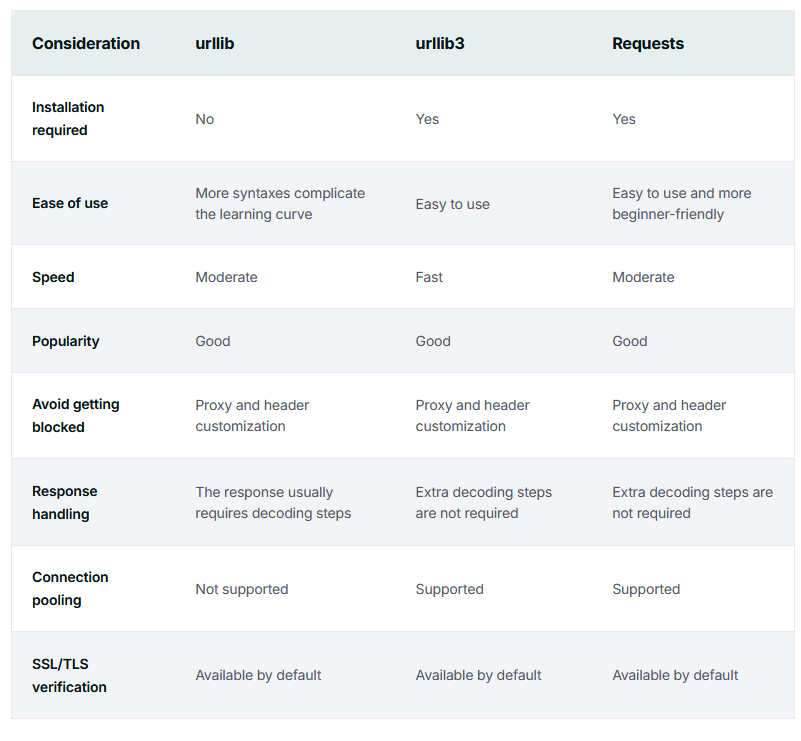

In [8]:
import json
import urllib

CITY = 'Brooklyn'

PATH_TO_KEY = r'C:\Users\sstucker\Documents\JTC\AISE 25\api.env'
with open(PATH_TO_KEY, 'r') as f:
    api_key = f.read().strip().split('=')[1]

params = {
    'q': CITY,
    'appid': api_key,
    'units': 'imperial',
    'limit': 1
}

url = "http://api.openweathermap.org/data/2.5/weather?" + urllib.parse.urlencode(params)

response = urllib.request.urlopen(url)

d = json.loads(response.read())

# print(json.dumps(d, indent=2))

feels_like = d['main']['feels_like']
print('Feels like', float(feels_like), 'degrees in', CITY)

Feels like 73.65 degrees in Brooklyn


In [7]:
import json
import requests

params = {
    'q': CITY,
    'appid': api_key,
    'units': 'imperial',
    'limit': 1
}

url = "http://api.openweathermap.org/data/2.5/weather"

response = requests.get(url, params=params)
d = response.json()  # Built-in JSON parsing

feels_like = d['main']['feels_like']
print('Feels like', float(feels_like), 'degrees in', CITY)

Feels like 73.65 degrees in Brooklyn


## Partials

In [11]:
def greet(name):
    print(f"Hello {name}!")

other_function = greet

other_function("Steve")

Hello Steve!


In [14]:
def create_greeter(name):
    def greeter():
        print(f"Hello {name}")
    return greeter

alice_greeter = create_greeter("Alice")
steve_greeter = create_greeter("Steve")

alice_greeter()
steve_greeter()

Hello Alice
Hello Steve


In [16]:
user_1_key = "ABCD-1234"
user_2_key = "EFGH-5678"

def create_api_get(api_key, endpoint):  # function factory

    def api_get(endpoint, api_key=api_key):
            # Dummy code:
            data = ''
            try:
                # Simulate an API call
                data = f"Got data from {endpoint} using key {api_key}"
            except Exception as e:
                print("API call failed:", e)
            return data 

    return api_get

get = create_api_get(user_1_key, "some/data")

get("https://api.data?foo")


'Got data from https://api.data?foo using key ABCD-1234'

Quality of life feature: `functools.partial`

## Decorators


In [ ]:
import functools
import time

def timer_decorator(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        print(time.perf_counter() - start, 's elapsed')
        return result
    return wrapper

@timer_decorator
def square(n):
    time.sleep(1.0)
    return n * n

N = 2**8

print(square(N))

print('name of fn', square.__name__)


1.0000752999912947 s elapsed
65536
name of fn square


In [33]:
def authenticate(fixed_api_key):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            return func(*args, api_key=fixed_api_key, **kwargs)  # Call og function with key
        return wrapper
    return decorator

# wrapped_function = decorator_with_arg(arg)(original function)

# -- Dummy API interface functions --------------------------------

@authenticate(user_1_key)
def api_get(endpoint, api_key):
    data = f"Got data from {endpoint} using key {api_key}"
    print(data)
    return data

@authenticate(user_1_key)
def api_post(endpoint, payload, api_key):
    response = f"Posted {payload} to {endpoint} using key {api_key}"
    print(response)
    return response

@authenticate(user_1_key)
def api_patch(endpoint, payload, api_key):
    response = f"Patched {payload} to {endpoint} using key {api_key}"
    print(response)
    return response

@authenticate(user_1_key)
def api_delete(endpoint, api_key):
    response = f"Deleted at {endpoint} using key {api_key}"
    print(response)
    return response

# -----------------------------------------------------------------

data = api_get("/data/1")
resp = api_post("/data/1", {"name": "Alice"})
resp = api_patch("/data/1", {"name": "Alice Smith"})
resp = api_delete("/data/1")

# ---

print('__name__ of api_get:', api_get.__name__)
print('__name__ of api_post:', api_post.__name__)
print('__name__ of api_patch:', api_patch.__name__)
print('__name__ of api_delete:', api_delete.__name__)


Got data from /data/1 using key ABCD-1234
Posted {'name': 'Alice'} to /data/1 using key ABCD-1234
Patched {'name': 'Alice Smith'} to /data/1 using key ABCD-1234
Deleted at /data/1 using key ABCD-1234
__name__ of api_get: api_get
__name__ of api_post: api_post
__name__ of api_patch: api_patch
__name__ of api_delete: api_delete


To summarize: boilerplate for two cases of decorator use

In [ ]:
# -- Decorator WITHOUT arguments ---------------------

def decorator(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):  # The wrapper fn
        # ...
        # Your code goes here
        # ...
        result = func(*args, **kwargs)
        # ... Maybe more of your code here?
        return result
    return wrapper

# wrapper_func = decorator(original_func)

# -- Decorator WITH arguments ---------------------

def decorator_with_args(arg1, arg2):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # ...
            # Your code goes here (probably gonna use arg1 and arg2)
            # ...
            result = func(*args, **kwargs)
            # ... Maybe more of your code here?
            return result
        return wrapper
    return decorator

# wrapped_func = decorator_with_args(arg1, arg2)(original_func)

### Logging

Time module:

In [36]:
import time

print(time.time())  # get current time in seconds since epoch
print(time.localtime())  # get more interpretable local time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

1759878691.1502783
time.struct_time(tm_year=2025, tm_mon=10, tm_mday=7, tm_hour=19, tm_min=11, tm_sec=31, tm_wday=1, tm_yday=280, tm_isdst=1)
2025-10-07 19:11:31


In [ ]:
log_msgs = []  # Logging collection

def authenticate(fixed_api_key):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            return func(*args, api_key=fixed_api_key, **kwargs)  # Call og function with key
        return wrapper
    return decorator

def log(log_msgs: list):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            log_entry = timestamp
            log_msgs.append(log_entry)
        return wrapper
    return decorator

# -- Dummy API interface functions --------------------------------

@authenticate(user_1_key)
def api_get(endpoint, api_key):
    data = f"Got data from {endpoint} using key {api_key}"
    print(data)
    return data

@authenticate(user_1_key)
def api_post(endpoint, payload, api_key):
    response = f"Posted {payload} to {endpoint} using key {api_key}"
    print(response)
    return response

@authenticate(user_1_key)
def api_patch(endpoint, payload, api_key):
    response = f"Patched {payload} to {endpoint} using key {api_key}"
    print(response)
    return response

@authenticate(user_1_key)
def api_delete(endpoint, api_key):
    response = f"Deleted at {endpoint} using key {api_key}"
    print(response)
    return response

# -----------------------------------------------------------------

data = api_get("/data/1")
resp = api_post("/data/1", {"name": "Alice"})
resp = api_patch("/data/1", {"name": "Alice Smith"})
resp = api_delete("/data/1")

# ---



Got data from /data/1 using key ABCD-1234
Posted {'name': 'Alice'} to /data/1 using key ABCD-1234
Patched {'name': 'Alice Smith'} to /data/1 using key ABCD-1234
Deleted at /data/1 using key ABCD-1234
